## 데이터 일차 가공 및 모델 학습/예측/평가

<h4> 데이터 로드

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('./creditcard/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [134]:
card_df.shape

(284807, 31)

<h4> 원본 DataFrame은 유지하고 데이터 가공을 위한 DataFrame을 복사하여 반환

In [135]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사 한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df = None) :
    df_copy = df.copy()
    df_copy.drop('Time', axis =1 , inplace=True)
    return df_copy

<h4> 학습과 테스트 데이터 세트를 반환하는 함수 생성. 사전 데이터 처리가 끝난 뒤 해당 함수 호출

In [136]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df = None) :
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    x_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]
    
    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    x_train, x_test, y_train, y_test = train_test_split(x_features, y_target,
                                                       test_size = 0.3, random_state=0, stratify=y_target)
    # 학습과 테스트 데이터 세트 반환
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = get_train_test_dataset(card_df)

In [137]:
print("학습 데이터 레이블 값 비율")
print(y_train.value_counts()/y_train.shape[0] * 100)
print("테스트 데이터 레이블 값 비율")
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [138]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

# 수정된 get_clf_eval() 함수 
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [139]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()

lr_clf.fit(x_train, y_train)

lr_pred = lr_clf.predict(x_test)
lr_pred_proba = lr_clf.predict_proba(x_test)[:, 1]

# 3장에서 사용한 get_clf_eval() 함수를 이용하여 평가 수행. 
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1: 0.7149, AUC:0.9592


<h4> 앞으로 피처 엔지니어링을 수행할 때마다 모델을 학습/예측/평가하므로 이를 위한 함수 생성

In [140]:
# 인자로 사이킷런의 Estimator객체와, 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행.
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)
    

<h4>LightGBM 학습/예측/평가.</h4>

<p>(boost_from_average가 True일 경우 레이블 값이 극도로 불균형 분포를 이루는 경우 재현률 및 ROC-AUC 성능이 매우 저하됨.)
<p>LightGBM 2.1.0 이상 버전에서 이와 같은 현상 발생

In [141]:
import lightgbm

lightgbm.__version__

'3.3.1'

In [142]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train = x_train, ftr_test=x_test, tgt_train = y_train, tgt_test = y_test )

오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790


## 중요 데이터 분포도 변환 후 모델 학습/예측/평가
<h4> 중요 feature의 분포도 확인

<AxesSubplot:xlabel='Amount', ylabel='Density'>

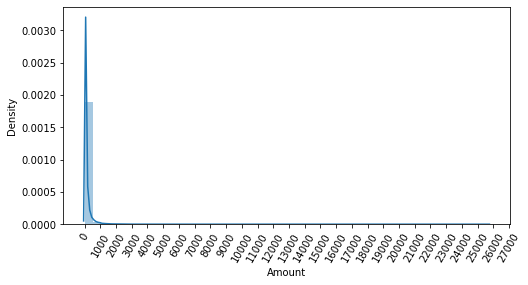

In [143]:
import seaborn as sns

plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000), rotation=60)
sns.distplot(card_df['Amount'])

<h4> 데이터 사전 가공을 위한 별도의 함수에 StandardScaler를 이용하여 Amount 피처 변환

In [144]:
from sklearn.preprocessing import StandardScaler

# 사이킷런의 StandardScaler를 이용하여 정규분포 형태로 Amount 피처값 변환하는 로직으로 수정. 
def get_preprocessed_df(df=None):
    df_copy=df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    
    # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
    df_copy.insert(0,'Amount_Scaled', amount_n)
    
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'],axis = 1, inplace =True)
    return df_copy

<h4> StandardScaler 변환 후 로지스틱 회귀 및 LightGBM 학습/예측/평가

In [145]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행. 
x_train, x_test, y_train, y_test = get_train_test_dataset(card_df)

print("### 로지스틱 회귀 예측 성능 ###")
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train = x_train, ftr_test = x_test, tgt_train = y_train, tgt_test = y_test)

print("### LightGBM 예측 성능 ###")
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train = x_train, ftr_test = x_test, tgt_train = y_train, tgt_test = y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.9702
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500,    F1: 0.8409, AUC:0.9779


<h4> Amount를 로그 변환

In [146]:
def get_preprocessed_df(df=None) :
    df_copy = df.copy()
    # 넘파이의 log1p( )를 이용하여 Amount를 로그 변환 
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled',amount_n)
    df_copy.drop(['Time','Amount'],axis=1, inplace=True )
    return df_copy

In [147]:
# log1p와 expm1 설명
import numpy as np

print(1e-1000 == 0.0)

print(np.log(1e-1000))

print(np.log(1e-1000 + 1))
print(np.log1p(1e-1000))

True
-inf
0.0
0.0


In [148]:
var_1 = np.log1p(100)
# expm1 은 다시 원본 값으로 -1 하겠다는 것.
var_2 = np.expm1(var_1)
print(var_1,"\n",var_2)

4.61512051684126 
 100.00000000000003


In [149]:
x_train, x_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=x_train, ftr_test=x_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=x_train, ftr_test=x_test, tgt_train=y_train, tgt_test=y_test)

# 재현율, 정밀도 F1 AUC 가 늘어남.

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1: 0.7149, AUC:0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9796


## 이상치 데이터 제거 후 모델 학습/예측/평가
<h4> 각 피처들의 상관 관계를 시각화. 결정 레이블인 class 값과 가장 상관도가 높은 피처 추출

<AxesSubplot:>

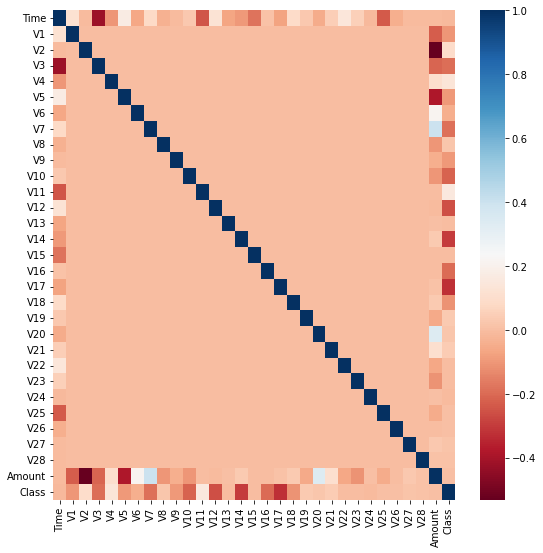

In [150]:
import seaborn as sns

plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

<h4> Dataframe에서 outlier에 해당하는 데이터를 필터링하기 위한 함수 생성. outlier 레코드의 index를 반환함.

In [151]:
import numpy as np

def get_outlier(df=None, column=None, weight = 1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values,25)
    quantile_75 = np.percentile(fraud.values,75)
    
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val) ].index
    
    return outlier_index

In [152]:
np.max(card_df['V14'])

10.5267660517847

In [153]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print("이상치 데이터 인덱스 : ",outlier_index)

이상치 데이터 인덱스 :  Int64Index([8296, 8615, 9035, 9252], dtype='int64')


<h4> 로그 변환 후 V14 피처의 이상치 데이터를 삭제한 뒤 모델들을 재 학습/예측/평가

In [154]:
# get_processed_df( )를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경. 
def get_processed_df(df=None) :
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

x_train, x_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=x_train, ftr_test=x_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=x_train, ftr_test=x_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1: 0.7149, AUC:0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9796


## SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

In [159]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
x_train_over, y_train_over = smote.fit_resample(x_train, y_train)
print("SMOTE 적용 전 학습용 피처/레이블 데이터 세트 " ,x_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', x_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

# 오버 샘플링 -> 데이터 증식

SMOTE 적용 전 학습용 피처/레이블 데이터 세트  (199364, 29) (199364,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 0    199020
1    199020
Name: Class, dtype: int64


In [157]:
y_train.value_counts()

0    199020
1       344
Name: Class, dtype: int64

<h4> 로지스틱 회귀로 학습/예측/평가

In [170]:
lr_clf = LogisticRegression()
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train = x_train_over, ftr_test = x_test, tgt_train = y_train_over, tgt_test = y_test)

# 정밀도가 너무 낮아짐.

오차 행렬
[[83317  1978]
 [   15   133]]
정확도: 0.9767, 정밀도: 0.0630, 재현율: 0.8986,    F1: 0.1178, AUC:0.9803


<h4> Precision-Recall 곡선 시각화

In [164]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1) :
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

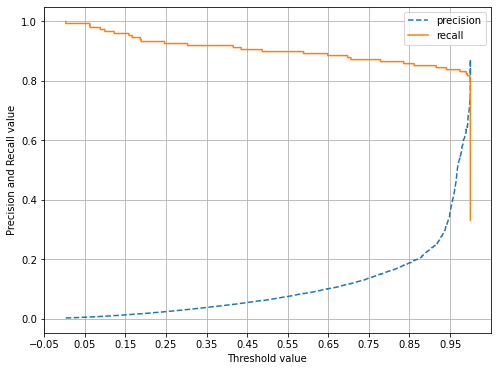

In [165]:
precision_recall_curve_plot( y_test, lr_clf.predict_proba(x_test)[:, 1] )

<h4> LightGBM 모델 적용

In [169]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=x_train_over, ftr_test=x_test,tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85277    18]
 [   36   112]]
정확도: 0.9994, 정밀도: 0.8615, 재현율: 0.7568,    F1: 0.8058, AUC:0.9780


In [178]:
print("데이터 가공 유형 | 머신러닝 알고리즘 |    정밀도    재현율    ROC-AUC\n")
print("-"*80)
print("                   로지스틱 회귀         0.8738    0.6081    0.9709\n")
print("데이터 변환 없음    LightGBM             0.9492    0.7568    0.9797\n")
print("-"*80)
print("                   로지스틱 회귀         0.8824    0.6081    0.9721\n")
print("데이터 로그 변환    LightGBM             0.9576    0.7635    0.9786\n")
print("-"*80)
print("                    로지스틱 회귀        0.8829    0.6712    0.9747\n")
print("이상치 데이터 제거  LightGBM             0.9680    0.8288    0.9831\n")
print("-"*80)
print("                    로지스틱 회귀        0.0540    0.9274    0.9737\n")
print("SMOTE 오버 샘플링   LightGBM             0.9394    0.8493    0.9778\n")                   

데이터 가공 유형 | 머신러닝 알고리즘 |    정밀도    재현율    ROC-AUC

--------------------------------------------------------------------------------
                   로지스틱 회귀         0.8738    0.6081    0.9709

데이터 변환 없음    LightGBM             0.9492    0.7568    0.9797

--------------------------------------------------------------------------------
                   로지스틱 회귀         0.8824    0.6081    0.9721

데이터 로그 변환    LightGBM             0.9576    0.7635    0.9786

--------------------------------------------------------------------------------
                    로지스틱 회귀        0.8829    0.6712    0.9747

이상치 데이터 제거  LightGBM             0.9680    0.8288    0.9831

--------------------------------------------------------------------------------
                    로지스틱 회귀        0.0540    0.9274    0.9737

SMOTE 오버 샘플링   LightGBM             0.9394    0.8493    0.9778

